In [1]:
import numpy as np
import matplotlib.pyplot as plt
from auxiliary.tauchen import approx_markov
from auxiliary.FirmInvestmentModel import FirmInvestmentModel, solve_model_notreshaped
from auxiliary.helpers_plotting import line_plot, threedim_plot
from auxiliary.helpers_general import gridlookup
from auxiliary.helpers_numba import np_cumsum_axis1
from auxiliary.helpers_calcmoments import *

In [2]:
# Initialization for the creation of the mgrid (that uses the not-jittable function above and hence is created outside the class def)
seed = 10082021

nz = 11         # Number of grid points for TFP
emean = 0.0     # Mean of innovations to firm TFP
sigma_z = 0.15  # Standard Deviations of innovations
rho = 0.7       # TFP persistence
multiple = 2.575 # Number of standard deviations the grid should span

# Productivity shock grid and transition probability matrix
np.random.seed(seed)
mgrid, pr_mat_m = approx_markov(rho, sigma_z, multiple, nz)
mgrid = np.exp(mgrid)

In [3]:
# Test
terry = FirmInvestmentModel(
            alpha=0.5,          
            delta=0.05,
            mgrid=mgrid,
            pr_mat_m=pr_mat_m)

In [4]:
 # Test
 V, polind, pol, equity_iss = solve_model_notreshaped(terry)

 V = np.reshape(V, (terry.nz, terry.nk))
 polind = np.reshape(polind, (terry.nz, terry.nk))
 pol = np.reshape(pol, (terry.nz, terry.nk))
 equity_iss = np.reshape(equity_iss, (terry.nz, terry.nk))

25 ( 0.00018670326615222166  error)

Converged in 27  iterations.


In [5]:

def visualize(alpha, delta, mgrid, pr_mat_m):
    """
    Visualizes the model solution (in 2D and 3D) taking alpha and delta as input for instantiating the class FirmInvestmentModel.

    Input
    -----
    * alpha:    parameter of interest (capital's share of output)
    * delta:    parameter of interest (depreciation rate)
    
    Output
    ------
    plots
    """
    
    # Create instance of the class FirmInvestmentModel
    terry = FirmInvestmentModel(alpha=alpha, delta=delta, mgrid=mgrid, pr_mat_m=pr_mat_m)

    # Solve the model
    V, polind, pol, equity_iss = solve_model_notreshaped(terry)

    # Reshape
    V = np.reshape(V, (terry.nz, terry.nk))
    polind = np.reshape(polind, (terry.nz, terry.nk))
    pol = np.reshape(pol, (terry.nz, terry.nk))
    equity_iss = np.reshape(equity_iss, (terry.nz, terry.nk))

    # Create contour lines
    line_plot(terry.kvec, V, terry.nz, 'Firm Capital k', 'V(z,k)', "Firm Value, (alpha, delta) = ({}, {})".format(alpha, delta))
    line_plot(terry.kvec, pol, terry.nz, 'Firm Capital k', 'kprime(z,k)', "Firm Capital Choice, (alpha, delta) = ({}, {})".format(alpha, delta))
    line_plot(terry.kvec, equity_iss, terry.nz, 'Firm Capital k', 'Negative Part(Equity Issuance)', "Firm Equity Issuance, (alpha, delta) = ({}, {})".format(alpha, delta))

    # Create 3D plots
    threedim_plot(terry.mgrid, terry.kvec, V, "z", "k", "V(z,k)", "Firm Value, (alpha, delta) = ({}, {})".format(alpha, delta))
    threedim_plot(terry.mgrid, terry.kvec, pol, "z", "k", "kprime(z,k)", "Firm Capital Choice, (alpha, delta) = ({}, {})".format(alpha, delta))
    threedim_plot(terry.mgrid, terry.kvec, equity_iss, "z", "k", "Negative Part(Equity Issuance)", "Negative Part(Equity Issuance), (alpha, delta) = ({}, {})".format(alpha, delta))
    


25 ( 0.00018670326615222166  error)

Converged in 27  iterations.


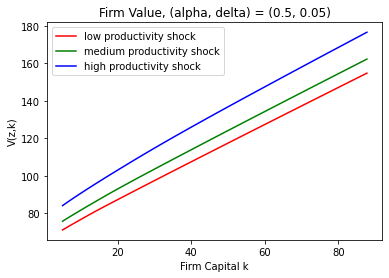

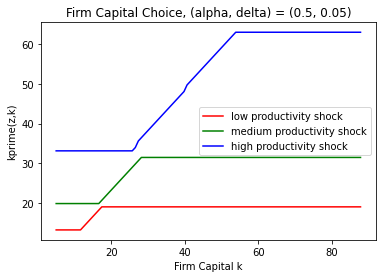

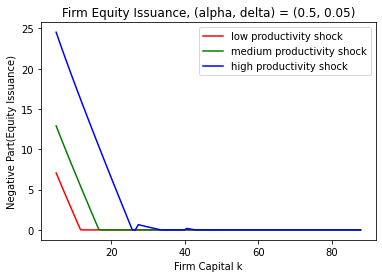

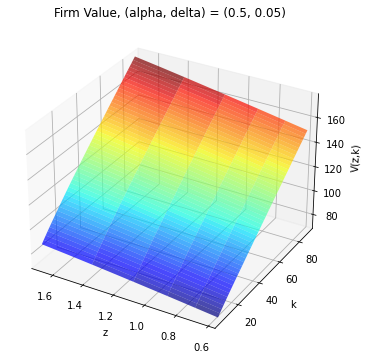

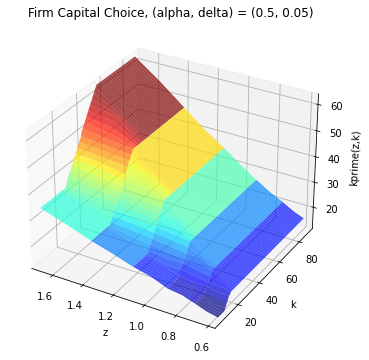

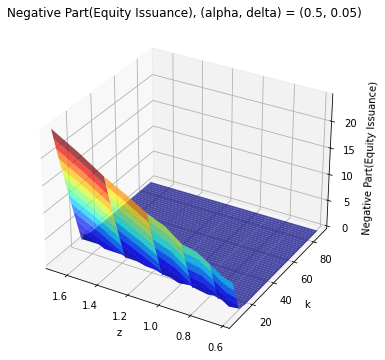

In [6]:
visualize(alpha=0.5, delta=0.05, mgrid=mgrid, pr_mat_m=pr_mat_m)

In [7]:
#@jit(nopython=True)
def simulate(terry, NYearsPerFirms=30, NFirms=10, seed=10082021, burnin=200):
    """
    Simulates a panel.

    Paramters
    ---------
    * terry:                    an instance of the class FirmInvestmentModel
    * NYearsPerFirm:            number of years per firm
    * NFirms:                   number of firms
    * seed:                     seed
    * burnin:                   burn-in period (i.e. number of first periods to be added first and then excluded in the final simulated panel)

    Output
    ------
    * Simdata (dimension (NYearsPerFirm x NFirms) x 8) with the following columns
    ** col1: id of the firm
    ** col2: year
    ** col3: profitability = z*(k^alpha)/K
    ** col4: investment rate = I/K
    ** col5: decision rule (issue equity or not)
    ** col6: y = zsim(t,i) * (k^alpha)
    ** col7: k
    ** col8: z
    """
    # Solve the model for the instance terry
    V, polind, pol, equity_iss = solve_model_notreshaped(terry)

    # Reshape
    pol = np.reshape(pol, (terry.nz, terry.nk))

    # Set seed
    np.random.seed(seed)

    # Total time for the loop
    NyearsPerFirmsburn = NYearsPerFirms + burnin
    k0val = (terry.kvec[0] + terry.kvec[terry.nk-1])/2

    # vector that stores the value for z
    zsim = np.zeros((NyearsPerFirmsburn, NFirms))
    izsim = zsim.copy()
    
    # At time 1, for each firm, draws an initial z process from the stationary distribution of z (stationary means 10000 draws)
    pi00 = np.linalg.matrix_power(terry.pr_mat_m, 10000)
    pi0 = pi00[0,0:nz-1]

    # cumulative distribution function of the stationary distribution
    cumpi0 = np.cumsum(pi0) # here the original np.cumsum works, since it is a 1d array
    
    runif = np.random.uniform(0,1, size=(NyearsPerFirmsburn, NFirms))

    # Draw and store the initial values of z
    for i in range(0, NFirms):
        izsim[0,i] = np.sum(((runif[0, i] - cumpi0) >= 0)*1)
        izsim[0,i] = min([int(izsim[0,i]) + 1, nz])
        zsim[0,i]  = mgrid[int(izsim[0,i])]

    # Simulate the process for all the other z
    cumpiz = np_cumsum_axis1(terry.pr_mat_m)
    NyearsPerFirms1 = NyearsPerFirmsburn-1
    for i in range(0, NFirms):
        for t in range(0, NyearsPerFirms1):
            cumpizi = cumpiz[int(izsim[t, i])-1, :]
            izsim[t+1, i] = np.sum(((runif[t,i] - cumpizi) >= 0)*1)
            izsim[t+1, i] = min([izsim[t+1, i]+1, nz])
            zsim[t+1, i] = terry.mgrid[int(izsim[t+1, i])-1]

    # storage variables       
    ksim = np.zeros((NyearsPerFirmsburn+1, NFirms))
    ksim[0, 0:NFirms] = k0val #do all firms start with the same capital? check def of k0val and terrys kvec
    ysim = np.zeros((NyearsPerFirmsburn, NFirms))
    # Important to make deep copies not pointers (!)
    esim = ysim.copy() #?
    profitsim = esim.copy()
    profitabilitysim = esim.copy()
    investmentrate = esim.copy()
    
    # Simulate panel of firms
    # double loop on time and firm
    for i in range(0, NFirms):
        for t in range(0, NyearsPerFirmsburn):
            kval = ksim[t, i]
            iz = izsim[t, i]
            iloc = gridlookup(terry.nk, terry.kvec, kval)
            weight = (terry.kvec[iloc+1] - kval) / ((terry.kvec[iloc+1]) - terry.kvec[iloc])
            kfval = pol[int(iz)-1, iloc]*weight + pol[int(iz)-1, iloc+1]*(1-weight)

            ksim[t+1, i] = kfval

            ysim[t, i] = zsim[t, i-1]*(kval**terry.alpha)
            profitabilitysim[t, i] = ysim[t, i]/kval
            esim[t, i] = max(kfval - (ysim[t, i] + (1-terry.delta)*kval),  0)
            investmentrate[t, i] = (kfval - (1-terry.delta)*kval)/kval
            if (esim[t, i]>0):
                esim[t, i] = esim[t, i]*(1+terry._lambda)
                profitsim[t, i] = (1+terry._lambda)*(ysim[t, i] + (1-terry.delta)*kval - kfval)
            else:
                profitsim[t, i] = ysim[t, i] + (1-terry.delta)*kval - kfval
                
    
                
    k = 8 # number of columns in Simdata
    SimData = np.zeros((NFirms*NYearsPerFirms, k)) # Allocate final panel

    # Fill final panel (see description of function)
    for id_n in range(0, NFirms):
        SimData[(id_n*NYearsPerFirms):(id_n+1)*NYearsPerFirms, ] = (
            np.concatenate((

            np.expand_dims(np.repeat(np.array([id_n]), NYearsPerFirms), axis = 1),
            np.expand_dims(np.arange(0, NYearsPerFirms), axis = 1),
            np.expand_dims(profitabilitysim[(burnin):(burnin+NYearsPerFirms), id_n], axis = 1),
            np.expand_dims(investmentrate[(burnin):(burnin+NYearsPerFirms), id_n], axis = 1),
            np.expand_dims(esim[(burnin):(burnin+NYearsPerFirms), id_n], axis = 1),
            np.expand_dims(ysim[(burnin):(burnin+NYearsPerFirms), id_n], axis = 1),
            np.expand_dims(ksim[(burnin):(burnin+NYearsPerFirms), id_n], axis = 1),
            np.expand_dims(zsim[(burnin):(burnin+NYearsPerFirms), id_n], axis = 1)

            ), axis = 1)
        )

    return SimData

In [8]:
sim = simulate(terry)
print(sim.shape)

25 ( 0.00018670326615222166  error)

Converged in 27  iterations.
(300, 8)


In [13]:
sample_data = import_data("data/RealData.csv", ["%firm_id", "year", "profitability", "inv_rate"])

c:\Users\Admin\Documents\Project_Struct_Est_Corp_Fin\ose-scientific-computing-course-default101\auxiliary\helpers_calcmoments.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(data.columns.difference(to_keep), 1, inplace=True)


In [10]:
sample_data = import_data("data/RealData.csv", ["%firm_id", "year", "profitability", "inv_rate"])
sample_moments = calc_moments(sample_data)
sample_data_adj = add_deviations_from_sample_mean(sample_data)

vector_n = get_nyears_per_firm(sample_data)

In [12]:
sim_data = label_data(sim)
sim_moments = calc_moments(sim_data)
sim_data_adj = add_deviations_from_sample_mean(sim_data)

sim_data_adj.head(40)

,%firm_id,year,profitability,inv_rate,equity_iss,cashflow,capital,prod_shock,profitability_adj,inv_rate_adj
0,0,0,0.147348,-0.053104,0.000000,3.546394,24.068226,0.722878,0.165253,-0.048076
1,0,1,0.155586,0.164956,0.212379,3.358598,21.586697,0.897474,0.173492,0.169985
2,0,2,0.164180,0.050000,0.000000,3.951531,24.068226,0.805459,0.182086,0.055028
3,0,3,0.182936,0.050000,0.000000,4.402949,24.068226,0.805459,0.200842,0.055028
4,0,4,0.182936,0.050000,0.000000,4.402949,24.068226,0.805459,0.200842,0.055028
5,0,5,0.164180,0.050000,0.000000,3.951531,24.068226,0.805459,0.182086,0.055028
6,0,6,0.182936,0.187472,0.114625,4.402949,24.068226,1.000000,0.200842,0.192500
7,0,7,0.138157,0.201072,1.808537,3.782312,27.376931,1.114239,0.156062,0.206100
8,0,8,0.128772,-0.186240,0.000000,4.057967,31.512813,0.805459,0.146677,-0.181212
9,0,9,0.147348,0.153104,0.145473,3.546394,24.068226,0.897474,0.165253,0.158132
